In [2]:
import math

In [3]:
import numpy as np

In [4]:
import random

In [5]:
import timeit

In [6]:
import matplotlib.pyplot as plt

In [7]:
import matplotlib.gridspec as gridspec

In [8]:
def train_test_split():
    global X
    global Y
    all_indexes = list(range(len(X)))
    train_indexes = random.sample(all_indexes,4000)
    test_indexes = list(set(all_indexes)-set(train_indexes))
    train_X = [X[i] for i in train_indexes]
    train_Y = [Y[i] for i in train_indexes]
    test_X = [X[i] for i in test_indexes]
    test_Y = [Y[i] for i in test_indexes]
    return train_X,test_X,train_Y,test_Y

In [9]:
def random_split(inputs,outputs,prop):
    all_indexes = list(range(len(inputs)))
    split = int(prop*len(inputs))
    random_indexes = random.sample(all_indexes,split)
    random_inputs = [inputs[i] for i in random_indexes]
    random_outputs = [outputs[i] for i in random_indexes]
    return random_inputs,random_outputs

In [10]:
def get_label(point):
    if len(point)==0:
        return 0
    for i in range(len(point)):
        if point[i]==1:
            return i
    return 0

In [11]:
def get_cm(actuals,preds):
    if len(actuals)!=len(preds):
        print("Sizes don't match")
        return
    if len(actuals[0])!=len(preds[0]):
        print("Dimensions don't match")
        return
    cm = np.zeros((len(actuals[0]),len(preds[0])))
    for i in range(len(actuals)):
        actual = get_label(actuals[i])
        predicted = get_label(preds[i])
        cm[actual][predicted] += 1
    return cm

In [12]:
def get_error(preds,actuals):
    if len(actuals)!=len(preds):
        print("Sizes don't match")
        return
    if len(actuals[0])!=len(preds[0]):
        print("Dimensions don't match")
        return
    total_error = 0.0
    for i in range(len(actuals)):
        total_error += np.sum(np.square(np.array(actuals[i])-np.array(preds[i])))
    return total_error/2

In [13]:
def get_labeled_error(preds,actuals,labels,query_label):
    label_cnt = 0
    if len(actuals)!=len(preds):
        print("Sizes don't match")
        return
    if len(actuals[0])!=len(preds[0]):
        print("Dimensions don't match")
        return
    total_error = 0.0
    for i in range(len(actuals)):
        actual_label = get_label(labels[i])
        if(actual_label == query_label):
            label_cnt += 1
            total_error += np.sum(np.square(np.array(actuals[i])-np.array(preds[i])))
    total_error = (total_error/label_cnt) #normalizing by label count
    return total_error/2

In [14]:
fw = open("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//MNISTnumImages5000.txt","r")
lines = fw.readlines()
print("Number of lines read:",len(lines))

Number of lines read: 5000


In [15]:
X=[]
for line in lines:
    inputs = [float(i) for i in line.split("\t")]
    inputs.insert(0,1) #bias weight
    X.append(inputs)
print("Number of lines:%d, number of features:%d" %(len(X),len(X[0])))

Number of lines:5000, number of features:785


In [16]:
fw = open("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//MNISTnumLabels5000.txt","r")
lines = fw.readlines()
print("Number of lines read:",len(lines))

Number of lines read: 5000


In [17]:
Y=[]
for line in lines:
    nums = [0,1,2,3,4,5,6,7,8,9]
    y = [1 if (num==int(line)) else 0 for num in nums]
    Y.append(y)
print("Number of lines:%d, dimensions:%d" %(len(Y),len(Y[0])))

Number of lines:5000, dimensions:10


In [18]:
class Neuron:
    #initializing initial weights(including bias)
    def __init__(self,weights):
        self.weights = weights
        self.changes = np.zeros(len(weights)) #initial change initiated to all 0's
        
    #this function returns the sigmoid transformed output for the given input from a neuron
    def get_output(self,inputs):
        self.inputs = inputs
        self.net_input = self.compute()
        self.output = self.sigmoid()
        return self.output
    
    #this function computes to total net input over all input and weight values
    def compute(self):
        return np.dot(self.inputs,self.weights)
    
    #this function applies the sigmoid transformation to the total netinput
    def sigmoid(self):
        sig = 1 + math.exp(-self.net_input)
        return 1/sig
    
    #this method computers the squared error for a neuron
    def get_squared_error(self,actual_output):
        return 0.5 * (actual_output - self.output)**2
    
    #this method calculated delta for the specific neuron(useful for output layer)
    def calculate_delta(self,actual_output):
        error = actual_output - self.output
        differential = self.get_differential() #differential of sigmoid wrt to net input
        return error * differential #delta = error * differential
    
    def get_differential(self):
        return self.output*(1 - self.output)

In [19]:
#this class represents a layer of neurons
class Layer:
    '''initialization function
    neuron_cnt -> number of neurons in the layer
    initial_weights -> initial set of weights to be assigned for the neuron layer(including bias)'''
    def __init__(self,neuron_cnt,input_cnt):
        self.neurons = [] #list of neurons belonging to the layer
        for i in range(neuron_cnt):
            initial_weights = self.generate_weights(neuron_cnt,input_cnt)
            self.neurons.append(Neuron(initial_weights))
            
    #this method generates random gaussian weights
    def generate_weights(self,n,cnt):
        '''
        cnt = number of weights to be generated
        n = number of neurons
        '''
        std = np.sqrt(float(2/n))
        return np.random.normal(0.0,std,cnt)
    
    def update_outputs(self,inputs):
        results = []
        for neuron in self.neurons:
            results.append(neuron.get_output(inputs))
        return results
    def get_outputs(self):
        results = []
        for neuron in self.neurons:
            results.append(neuron.output)
        return results

In [20]:
#this class represents the entire network
class Network:
    
    def __init__(self,lrate_h,lrate_o,alpha,num_h_layers=1,hidden_cnts=[100],num_inputs=1,num_outputs=1):
        '''
        num_h_layer -> number of hidden layers to be used in the neural network
        num_outputs -> number of output neurons
        lrate_h -> learning rate to learn ip2h_weights
        lrate_o -> learning rate to learn h2o_weights
        '''
        self.lrate_h = lrate_h
        self.lrate_o = lrate_o
        self.alpha = alpha
        self.num_h_layers = num_h_layers
        self.num_outputs = num_outputs #number of output neurons
        self.hidden_cnts = hidden_cnts #number of neurons in each hidden layer
        self.input_dim = num_inputs #dimension of each input pattern
        self.hidden_layers = [] #list of hidden layers being used
        #print("Number of hidden layers:%d, Number of output neurons:%d, Input dimensions:%d" %(self.num_h_layers,self.num_outputs,self.input_dim))
        for i in range(self.num_h_layers): #initializing each hidden neuron layer
            if i==0:
                #initializing first hidden layer i.e input -> h1
                self.hidden_layers.append(Layer(self.hidden_cnts[i],self.input_dim))
            else:
                #initializing other hidden layer i.e h1->h2->....
                self.hidden_layers.append(Layer(self.hidden_cnts[i],self.hidden_cnts[i-1]))
        #initializing output layers using the weights from last hidden layer
        self.output_layer = Layer(self.num_outputs,self.hidden_cnts[self.num_h_layers-1])
        
    #this function performs the "feedforward" pass of the algorithm
    def feed_forward(self,inputs):
        hidden_outputs = {}#dict which accumulates outputs from all hidden layers
        final_outputs = [] #list of outputs from output(result) neurons
        for i in range(self.num_h_layers):
            outputs = [] 
            if i==0:
                #calculating outputs of first hidden layer using the Input pattern
                outputs = self.hidden_layers[i].update_outputs(inputs)
            else:
                #calculating outputs of other hidden layers using inputs from previous hidden layer
                outputs = self.hidden_layers[i].update_outputs(hidden_outputs[i])
            hidden_outputs[i]= outputs
        #calculating outputs of result neurons using inputs from the last hidden layer
        final_outputs = self.output_layer.update_outputs(hidden_outputs[self.num_h_layers-1])
        return final_outputs
    
    #this function calculates the deltai of output layer deltai = yi-yihat*fdash(si)
    def calc_o_deltas(self,training_output):
        output_deltas = []
        for i in range(self.num_outputs):
            output_deltas.append(self.output_layer.neurons[i].calculate_delta(training_output[i]))
        return output_deltas
    
    #this function calculates the deltaj of hidden layer deltaj = sigma wij*deltai*fdash(sj)
    def calc_h_deltas(self,output_deltas):
        hidden_deltas = {} #dictionary of deltas for each hidden layer in the order of last to first
        for i in range(self.num_h_layers-1,-1,-1): #looping over all hidden layers in descending order
            deltas = []
            if i==self.num_h_layers-1:
                #calculating delta of last hidden neuron layer based on output layer
                for j in range(self.hidden_cnts[i]):
                    delta = 0.0
                    for k in range(self.num_outputs):
                        #calculating  sigmawij*deltai component
                        delta += output_deltas[k] * self.output_layer.neurons[k].weights[j]
                    # sigma wij*deltaj*fdash
                    deltas.append(delta * self.hidden_layers[i].neurons[j].get_differential())
            else:
                #calculating delta of all other hidden neuron layers
                for j in range(self.hidden_cnts[i]):
                    delta = 0.0
                    for k in range(self.hidden_cnts[i+1]):
                        #calculating sigmawij*deltai component
                        delta += hidden_deltas[i+1][k] * self.hidden_layers[i+1].neurons[k].weights[j]
                    # sigma wij*deltaj*fdash
                    deltas.append(delta * self.hidden_layers[i].neurons[j].get_differential())
            hidden_deltas[i]=deltas
        return hidden_deltas
    
    #this function updates the weights of output layer
    def update_o_weights(self,output_deltas):
        for i in range(self.num_outputs):
            for j in range(len(self.output_layer.neurons[i].weights)):
                #deltawij = etao*deltai*hj
                weight_change = self.lrate_o*output_deltas[i]*self.output_layer.neurons[i].inputs[j]
                momentum = self.alpha*self.output_layer.neurons[i].changes[j] #momentum step
                self.output_layer.neurons[i].changes[j] = weight_change
                self.output_layer.neurons[i].weights[j] += weight_change + momentum
                
    #this function updates the weights of hidden layers
    def update_h_weights(self,hidden_deltas):
        for i in range(self.num_h_layers):
            for j in range(self.hidden_cnts[i]):
                for k in range(len(self.hidden_layers[i].neurons[j].weights)):
                    #deltawjk = etah*deltaj*xk
                    weight_change = self.lrate_h*hidden_deltas[i][j]*self.hidden_layers[i].neurons[j].inputs[k]
                    momentum = self.alpha*self.hidden_layers[i].neurons[j].changes[k] #momentum step
                    self.hidden_layers[i].neurons[j].changes[k] = weight_change
                    self.hidden_layers[i].neurons[j].weights[k] += weight_change + momentum
                        
    #this function performs the training process including "feedforward" and "backpropagation" step for each input
    def back_propagation(self,training_input,training_outputs):
        pred_output = self.feed_forward(training_input)
        output_deltas = self.calc_o_deltas(training_outputs)
        hidden_deltas = self.calc_h_deltas(output_deltas)
        self.update_o_weights(output_deltas)
        self.update_h_weights(hidden_deltas)
    
    #this function encodes the outputs as binary values
    def encode_output(self,output,mode):
        if len(output)==0:
            return 0
        decoded_output = []
        if mode=="none":
            return output
        if mode=="normal": #encoding using normal thresholds of 0.75 and 0.25 for classes 1 and 0
            for o in output:
                if o>=0.75:
                    decoded_output.append(1)
                elif o<=0.25:
                    decoded_output.append(0)
                else:
                    decoded_output.append(o)
            return decoded_output
        elif mode=="max":
            max_val = max(output)
            for o in output:
                if o==max_val:
                    decoded_output.append(1)
                else:
                    decoded_output.append(0)
            return decoded_output
    
    #this function predicts the output for given set of inputs
    def predict(self,test_inputs,mode):
        if len(test_inputs)==0:
            print("Input size is 0")
            return
        predicted_outputs = []
        for t in range(len(test_inputs)):
            outputs = self.feed_forward(test_inputs[t])
            encoded_outputs = self.encode_output(outputs,mode)
            predicted_outputs.append(encoded_outputs)
        return predicted_outputs
    
    #this function calculates total squared error across all training sets
    def calculate_squared_error(self,training_outputs):
        total_error = 0.0
        for i in range(len(training_outputs)):
            total_error += self.output_layer.neurons[i].get_squared_error(training_outputs[i])
        return total_error
    
    #this function saves all weights
    def save_weights(self,filename):
        fw = open(filename,"w")
        fw.write("*****HIDDEN TO OUTPUT******")
        for t in range(self.num_outputs):
            weights = self.output_layer.neurons[t].weights
            for w in weights:
                fw.write(str(w))
                fw.write(" ")
            fw.write("\n")
        fw.write("*****INPUT TO HIDDEN******")
        for t in range(self.num_h_layers):
            for i in range(self.hidden_cnts[t]):
                weights = self.hidden_layers[t].neurons[i].weights
                for w in weights:
                    fw.write(str(w))
                    fw.write(" ")
                fw.write("\n")
        fw.close()

In [21]:
def calc_hit_rate(predicted,actual):
    if(len(predicted)!=len(actual)):
        print("Lengths do not match")
    hit_cnt = 0
    for i in range(len(predicted)):
        if predicted[i]==actual[i]:
            hit_cnt += 1
    return float(hit_cnt)/len(predicted)

In [22]:
def convert_to_grayScale(weights):
    grayscale = []
    for i in range(1,29):
        grayscale.append(weights[28*(i-1):28*i])
    return grayscale

In [23]:
[train_X,test_X,train_Y,test_Y] = train_test_split()
print(len(train_X),len(test_X),len(train_Y),len(test_Y))

4000 1000 4000 1000


In [24]:
#training hidden neuron counts
#self,lrate_h,lrate_o,alpha,num_h_layers=1,hidden_cnts=[100],num_inputs=1,num_outputs=1
hidden_cnts = [100,150,200,250,300]
train_rates = {}
test_rates = {}
num_epochs = 100
for cnt in hidden_cnts:
    train_hit_rate = 0.0
    test_hit_rate = 0.0
    print("Counts:",cnt)
    nn = Network(0.05,0.05,0.1,1,[cnt],785,10)#neural network with 400 random training points for each epoch
    for t in range(1,num_epochs+1):
        if(t%10==0):
            print("Epoch:",t)
        [inputs,outputs] = random_split(train_X,train_Y,0.025)
        #epoch_start_time = timeit.default_timer()
        for k in range(len(inputs)): #backpropagation for each point
            nn.back_propagation(inputs[k],outputs[k])
    train_preds = nn.predict(train_X,"normal")
    train_rates[str(cnt)] = calc_hit_rate(train_preds,train_Y)
    test_preds = nn.predict(test_X,"max")
    test_rates[str(cnt)] = calc_hit_rate(test_preds,test_Y)
print("Finished")

Counts: 100
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Counts: 150
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Counts: 200
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Counts: 250
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Counts: 300
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Finished


In [25]:
train_vals,test_vals = [],[]
for cnt in hidden_cnts:
    train_vals.append(train_rates[str(cnt)])
    test_vals.append(test_rates[str(cnt)])

In [26]:
train_rates

{'100': 0.61, '150': 0.62875, '200': 0.657, '250': 0.676, '300': 0.68175}

In [27]:
test_rates

{'100': 0.869, '150': 0.883, '200': 0.877, '250': 0.883, '300': 0.89}

In [28]:
plt.plot(hidden_cnts,train_vals,'-r',label="Training")
plt.plot(hidden_cnts,test_vals,'-b',label="Testing")
plt.legend(loc='upper center')
plt.xlabel("Hidden Counts")
plt.ylabel("Hit Rate")
plt.title("Hidden Neuron Count vs Hit Rate(100 Epochs)")
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//hidden_vs_hitrate2")
plt.close()

In [29]:
#training learning rate
#self,lrate_h,lrate_o,alpha,num_h_layers=1,hidden_cnts=[100],num_inputs=1,num_outputs=1
lrates = np.arange(0.01,0.110,0.01)
train_rates = {}
test_rates = {}
num_epochs = 100
for lrate in lrates:
    train_hit_rate = 0.0
    test_hit_rate = 0.0
    print("lrate:",lrate)
    nn = Network(lrate,lrate,0.1,1,[150],785,10)#neural network with 400 random training points for each epoch
    for t in range(1,num_epochs+1):
        if(t%10==0):
            print("Epoch:",t)
        [inputs,outputs] = random_split(train_X,train_Y,0.025)
        #epoch_start_time = timeit.default_timer()
        for k in range(len(inputs)): #backpropagation for each point
            nn.back_propagation(inputs[k],outputs[k])
    train_preds = nn.predict(train_X,"normal")
    train_rates[str(lrate)] = calc_hit_rate(train_preds,train_Y)
    test_preds = nn.predict(test_X,"max")
    test_rates[str(lrate)] = calc_hit_rate(test_preds,test_Y)
print("Finished")

lrate: 0.01
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
lrate: 0.02
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
lrate: 0.03
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
lrate: 0.04
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
lrate: 0.05
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
lrate: 0.060000000000000005
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
lrate: 0.06999999999999999
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
lrate: 0.08
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
lrate: 0.09
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epo

In [30]:
train_vals, test_vals = [],[]
for lrate in lrates:
    train_vals.append(train_rates[str(lrate)])
    test_vals.append(test_rates[str(lrate)])

In [31]:
plt.plot(lrates,train_vals,'-r',label="Training Hit Rate")
plt.plot(lrates,test_vals,'-b',label="Testing Hit Rate")
plt.legend(loc='upper right')
plt.xlabel("Learning Rate")
plt.ylabel("Hit Rate")
plt.title("Learning Rate vs Hit Rate(100 Epochs)")
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//learning_vs_hitrate")
plt.close()

In [32]:
#training alpha value
#self,lrate_h,lrate_o,alpha,num_h_layers=1,hidden_cnts=[100],num_inputs=1,num_outputs=1
alphas = [0.05,0.1,0.15,0.2,0.25]
train_rates = {}
test_rates = {}
num_epochs = 100
for alpha in alphas:
    train_hit_rate = 0.0
    test_hit_rate = 0.0
    print("alpha:",alpha)
    nn = Network(0.1,0.1,alpha,1,[150],785,10)#neural network with 400 random training points for each epoch
    for t in range(1,num_epochs+1):
        if(t%10==0):
            print("Epoch:",t)
        [inputs,outputs] = random_split(train_X,train_Y,0.025)
        #epoch_start_time = timeit.default_timer()
        for k in range(len(inputs)): #backpropagation for each point
            nn.back_propagation(inputs[k],outputs[k])
    train_preds = nn.predict(train_X,"normal")
    train_rates[str(alpha)] = calc_hit_rate(train_preds,train_Y)
    test_preds = nn.predict(test_X,"max")
    test_rates[str(alpha)] = calc_hit_rate(test_preds,test_Y)
print("Finished")

alpha: 0.05
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
alpha: 0.1
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
alpha: 0.15
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
alpha: 0.2
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
alpha: 0.25
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Finished


In [33]:
train_vals, test_vals = [],[]
for alpha in alphas:
    train_vals.append(train_rates[str(alpha)])
    test_vals.append(test_rates[str(alpha)])

In [34]:
plt.plot(alphas,train_vals,'-r',label="Training")
plt.plot(alphas,test_vals,'-b',label="Testing")
plt.legend(loc='upper right')
plt.xlabel("Learning Rate")
plt.ylabel("Hit Rate")
plt.title("Alpha vs Hit Rate(100 Epochs)")
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//alpha_vs_hitrate")
plt.close()

In [35]:
#final training step using stochastic gradient descent
#self,lrate_h,lrate_o,alpha,num_h_layers=1,hidden_cnts=[100],num_inputs=1,num_outputs=1
num_epochs = 1000
hit_rates = []
nn = Network(0.1,0.1,0.15,1,[150],785,10)#neural network with 400 random training points for each epoch
print("****starting****")
for t in range(1,num_epochs+1):
    [inputs,outputs] = random_split(train_X,train_Y,0.025)
    training_hit_rate = 0.0
    #epoch_start_time = timeit.default_timer()
    for k in range(len(inputs)): #backpropagation for each point
        nn.back_propagation(inputs[k],outputs[k])
    if t%10==0: #calculating hit rate for every 10 epochs
        predicted_outputs = nn.predict(inputs,"normal")
        hit_rate = calc_hit_rate(predicted_outputs,outputs)
        print("Epoch:%d, hit_rate:%f" %(t,hit_rate))
        hit_rates.append(hit_rate)
nn.save_weights("final_weights_1000.txt")
train_preds = nn.predict(train_X,"max")
train_cm = get_cm(train_Y,train_preds)
test_preds = nn.predict(test_X,"max")
test_cm = get_cm(test_Y,test_preds)
print("Finished")

****starting****
Epoch:10, hit_rate:0.520000
Epoch:20, hit_rate:0.620000
Epoch:30, hit_rate:0.700000
Epoch:40, hit_rate:0.780000
Epoch:50, hit_rate:0.730000
Epoch:60, hit_rate:0.740000
Epoch:70, hit_rate:0.720000
Epoch:80, hit_rate:0.850000
Epoch:90, hit_rate:0.840000
Epoch:100, hit_rate:0.770000
Epoch:110, hit_rate:0.770000
Epoch:120, hit_rate:0.710000
Epoch:130, hit_rate:0.780000
Epoch:140, hit_rate:0.740000
Epoch:150, hit_rate:0.810000
Epoch:160, hit_rate:0.810000
Epoch:170, hit_rate:0.850000
Epoch:180, hit_rate:0.830000
Epoch:190, hit_rate:0.910000
Epoch:200, hit_rate:0.840000
Epoch:210, hit_rate:0.870000
Epoch:220, hit_rate:0.860000
Epoch:230, hit_rate:0.920000
Epoch:240, hit_rate:0.860000
Epoch:250, hit_rate:0.890000
Epoch:260, hit_rate:0.900000
Epoch:270, hit_rate:0.920000
Epoch:280, hit_rate:0.950000
Epoch:290, hit_rate:0.930000
Epoch:300, hit_rate:0.950000
Epoch:310, hit_rate:0.940000
Epoch:320, hit_rate:0.980000
Epoch:330, hit_rate:0.900000
Epoch:340, hit_rate:0.920000
Epoch:

In [69]:
#final hit-rates
test_pred_outputs = nn.predict(test_X,"max")
test_hit_rate = calc_hit_rate(test_pred_outputs,test_Y)

train_pred_outputs = nn.predict(train_X,"normal")
train_hit_rate = calc_hit_rate(train_pred_outputs,train_Y)

#saving predicted labels for future use
fw = open("Training_labels_1000.txt","w")
for output in train_pred_outputs:
    label = get_label(output)
    fw.write(str(label)+"\n")
fw.close()


fw = open("Training_labels_max_1000.txt","w")
for output in train_pred_outputs_max:
    label = get_label(output)
    fw.write(str(label)+"\n")
fw.close()


NameError: name 'train_pred_outputs_max' is not defined

In [39]:
for output in train_pred_outputs_max:
    label = get_label(output)
    fw.write(str(label)+"\n")
fw.close()

NameError: name 'train_pred_outputs_max' is not defined

In [44]:
#saving predicted labels for future use
fw = open("Test_labels_1000.txt","w")
for output in test_pred_outputs:
    label = get_label(output)
    fw.write(str(label)+"\n")
fw.close()

In [ ]:
train_pred_outputs_max = nn.predict(train_X,"max")
train_cm_max = get_cm(train_Y,train_pred_outputs_max)

In [ ]:
training_errors = 1 -np.array(hit_rates)
plt.plot(range(1,1001,10),training_errors)
plt.xlabel("Epochs")
plt.ylabel("Error Rate")
plt.title("Time series of error rate(1000 Epochs)")
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//error_timeseries(1000)")
plt.close()

In [ ]:
#{'0.08': 0.5155, '0.035': 0.46725, '0.06': 0.52425, '0.085': 0.526, '0.05': 0.51625, '0.065': 0.50625, 
#'0.005': 0.11875, '0.01': 0.23, '0.095': 0.54725, '0.03': 0.4385, '0.075': 0.53425, '0.045': 0.49175, 
#'0.04': 0.47, '0.02': 0.35725, '0.1': 0.53775, '0.055': 0.507, '0.09': 0.53975, '0.07': 0.5155, '0.015': 0.3165, '0.025': 0.4135}

In [ ]:
#{'100': 0.4545, '200': 0.482, '150': 0.48975}

In [ ]:
# auto-encoder

In [41]:
#cross validating learning rates
#self,lrate_h,lrate_o,alpha,num_h_layers=1,hidden_cnts=[100],num_inputs=1,num_outputs=1
lrates = np.arange(0.01,0.210,0.02)
train_errors = {}
test_errors = {}
num_epochs = 50
for lrate in lrates:
    train_hit_rate = 0.0
    test_hit_rate = 0.0
    print("lrate:",lrate)
    nn = Network(lrate,lrate,0.1,1,[150],785,785)#neural network with 400 random training points for each epoch
    for t in range(1,num_epochs+1):
        if(t%10==0):
            print("Epoch:",t)
        [inputs,outputs] = random_split(train_X,train_Y,0.025)
        #epoch_start_time = timeit.default_timer()
        for k in range(len(inputs)): #backpropagation for each point
            nn.back_propagation(inputs[k],inputs[k])
    train_preds = nn.predict(train_X,"none")
    train_errors[str(lrate)] = get_error(train_preds,train_X)
    test_preds = nn.predict(test_X,"none")
    test_errors[str(lrate)] = get_error(test_preds,test_X)
print("Finished")

lrate: 0.01
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
lrate: 0.03
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
lrate: 0.049999999999999996
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
lrate: 0.06999999999999999
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
lrate: 0.08999999999999998
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
lrate: 0.10999999999999997
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
lrate: 0.12999999999999998
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
lrate: 0.15
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
lrate: 0.16999999999999998
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
lrate: 0.18999999999999997
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Finished


In [46]:
train_errors

{'0.01': 49737.723096442605,
 '0.03': 28626.399073702254,
 '0.049999999999999996': 22077.256217219157,
 '0.06999999999999999': 18593.20059331895,
 '0.08999999999999998': 16983.88059285223,
 '0.10999999999999997': 16462.507951581858,
 '0.12999999999999998': 15579.158615205157,
 '0.15': 15472.91558790051,
 '0.16999999999999998': 15852.442010356684,
 '0.18999999999999997': 16763.43881725486}

In [47]:
test_errors

{'0.01': 12579.989914866166,
 '0.03': 7377.350076512519,
 '0.049999999999999996': 5733.616687035704,
 '0.06999999999999999': 4912.177748141567,
 '0.08999999999999998': 4561.2731918726595,
 '0.10999999999999997': 4465.062955324469,
 '0.12999999999999998': 4261.066510454432,
 '0.15': 4228.206106523967,
 '0.16999999999999998': 4328.721311938149,
 '0.18999999999999997': 4568.781493429739}

In [48]:
train_vals, test_vals = [],[]
for lrate in lrates:
    train_vals.append(train_errors[str(lrate)])
    test_vals.append(test_errors[str(lrate)])

In [49]:
lrates = np.arange(0.01,0.210,0.02)
train_vals = [99208.30,57307.14,43604.76,37749.79,34093.12,31666.06,31004.18,30736.009,32775.18,33264.38]
test_vals = [25231.35,14910.60,11579.97,10199.35,9281.81,8720.66,8627.07,8548.89,9058.94,9310.46]
train_vals = [vals/4000 for vals in train_vals]
test_vals = [vals/1000 for vals in test_vals]

In [50]:
plt.plot(lrates,train_vals,'-r',label="Training")
plt.plot(lrates,test_vals,'-b',label="Testing")
plt.legend(loc='upper right')
plt.xlabel("Learning Rate")
plt.ylabel("Normalized Squared Error")
plt.title("Learning Rate vs Squared Error(50 Epochs)")
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//lrate_vs_squarederror")
plt.close()

In [51]:
for i in range(100,301,50):
    print(i)

100
150
200
250
300


In [52]:
#cross-validating alpha
#self,lrate_h,lrate_o,alpha,num_h_layers=1,hidden_cnts=[100],num_inputs=1,num_outputs=1
alphas = [0.05,0.1,0.15,0.2,0.25]
train_errors = {}
test_errors = {}
num_epochs = 50
for alpha in alphas:
    train_hit_rate = 0.0
    test_hit_rate = 0.0
    print("alpha:",alpha)
    nn = Network(0.15,0.15,alpha,1,[150],785,785)#neural network with 400 random training points for each epoch
    for t in range(1,num_epochs+1):
        if(t%10==0):
            print("Epoch:",t)
        [inputs,outputs] = random_split(train_X,train_Y,0.025)
        #epoch_start_time = timeit.default_timer()
        for k in range(len(inputs)): #backpropagation for each point
            nn.back_propagation(inputs[k],inputs[k])
    train_preds = nn.predict(train_X,"none")
    train_errors[str(alpha)] = get_error(train_preds,train_X)
    test_preds = nn.predict(test_X,"none")
    test_errors[str(alpha)] = get_error(test_preds,test_X)
print("Finished")

alpha: 0.05
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
alpha: 0.1
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
alpha: 0.15
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
alpha: 0.2
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
alpha: 0.25
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Finished


In [53]:
train_errors

{'0.05': 15881.359805515985,
 '0.1': 16029.223338981432,
 '0.15': 15386.697028266535,
 '0.2': 15894.496891939552,
 '0.25': 15379.620849707466}

In [54]:
test_errors

{'0.05': 4310.37578538298,
 '0.1': 4346.525779924942,
 '0.15': 4204.269722941959,
 '0.2': 4355.023360766859,
 '0.25': 4189.04801577654}

In [55]:
train_vals, test_vals = [],[]
for alpha in alphas:
    train_vals.append(train_errors[str(alpha)])
    test_vals.append(test_errors[str(alpha)])

In [56]:
alphas = [0.05,0.1,0.15,0.2,0.25]
train_vals = [31101.07,31750.68,31264.08,30610.89,31794.04]
test_vals = [8682.46,8806.08,8668.63,8638.38,8980.46]
train_vals = [vals/4000 for vals in train_vals]
test_vals = [vals/1000 for vals in test_vals]

In [57]:
plt.plot(alphas,train_vals,'-r',label="Training")
plt.plot(alphas,test_vals,'-b',label="Testing")
plt.legend(loc='upper right')
plt.xlabel("Alpha")
plt.ylabel("Normalized Squared Error")
plt.title("Alpha vs Squared Error(50 Epochs)")
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//alpha_vs_squarederror")
plt.close()

In [58]:
#final training step using stochastic gradient descent
#self,lrate_h,lrate_o,alpha,num_h_layers=1,hidden_cnts=[150],num_inputs=1,num_outputs=1
num_epochs = 500
errors = []
nn = Network(0.15,0.15,0.20,1,[150],785,785)#neural network with 400 random training points for each epoch
print("****starting****")
for t in range(1,num_epochs+1):
    [inputs,outputs] = random_split(train_X,train_Y,0.025)
    training_hit_rate = 0.0
    #epoch_start_time = timeit.default_timer()
    for k in range(len(inputs)): #backpropagation for each point
        nn.back_propagation(inputs[k],inputs[k])
    if t%10==0: #calculating hit rate for every 10 epochs
        predicted_outputs = nn.predict(inputs,"none")
        error = get_error(predicted_outputs,inputs)
        print("Epoch:%d, error:%f" %(t,error))
        errors.append(error)
nn.save_weights("auto_encoder_final_weights_500.txt")
train_preds = nn.predict(train_X,"none")
train_error = get_error(train_preds,train_X)
test_preds = nn.predict(test_X,"none")
test_error = get_error(test_preds,test_X)
print("Final Training Error:%f Testing Error:%f" %(train_error,test_error))
print("Finished")

****starting****
Epoch:10, error:684.027974
Epoch:20, error:455.492799
Epoch:30, error:351.928509
Epoch:40, error:306.446176
Epoch:50, error:298.519030
Epoch:60, error:258.145314
Epoch:70, error:259.457654
Epoch:80, error:235.729982
Epoch:90, error:208.512434
Epoch:100, error:194.218252
Epoch:110, error:194.051207
Epoch:120, error:201.930933
Epoch:130, error:179.577333
Epoch:140, error:176.585174
Epoch:150, error:167.241141
Epoch:160, error:191.636799
Epoch:170, error:187.197814
Epoch:180, error:180.490882
Epoch:190, error:206.955010
Epoch:200, error:153.161414
Epoch:210, error:162.631806
Epoch:220, error:168.066626
Epoch:230, error:166.161925
Epoch:240, error:144.669948
Epoch:250, error:151.615147
Epoch:260, error:152.183871
Epoch:270, error:156.347988
Epoch:280, error:146.935465
Epoch:290, error:130.821999
Epoch:300, error:140.714053
Epoch:310, error:142.726391
Epoch:320, error:144.692508
Epoch:330, error:141.474866
Epoch:340, error:129.827553
Epoch:350, error:134.840946
Epoch:360, e

In [59]:
#hidden_weights = nn.get_hidden_weights()

In [60]:
print("Final Training Error:%f Testing Error:%f" %(train_error,test_error))

Final Training Error:6628.865091 Testing Error:2526.849410


ValueError: x and y must have same first dimension, but have shapes (100,) and (50,)

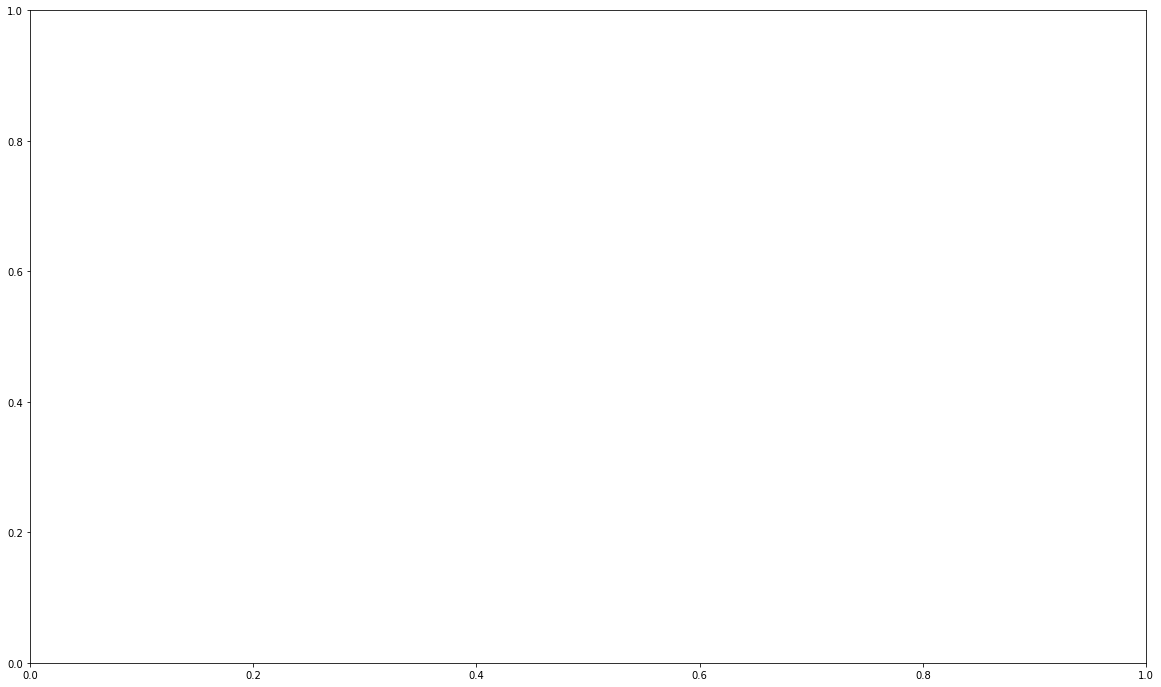

In [70]:
norm_errors = [(error/100)/784 for error in errors] #normalizing errors by number of points
plt.plot(range(1,1001,10),norm_errors)
plt.xlabel("Epochs")
plt.ylabel("Normalized Squared Error per neuron")
plt.title("Time series of squared error(1000 Epochs)")
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//squarederror_timeseries(1000)")
plt.close()

In [62]:
#training and testing errors
train_error = (train_error)/4000 #normalizing the squared error
test_error = (test_error)/1000
plt.rcParams["figure.figsize"] = (7,7)
y_pos =[0.5,1]
bars = [train_error,test_error]
plt.bar(y_pos, bars, align='center', alpha=0.4,width=0.1)
plt.xticks(y_pos,["Training Error","Testing Error"])
plt.ylabel('Normalized Squared Error')
plt.title('Training & Testing Squared Errors')
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//squared_error_bars(1000).png")
plt.close()

In [63]:
labeled_train_errors = []
labeled_test_errors = []
for i in range(10):
    tr_error = get_labeled_error(train_preds,train_X,train_Y,i)
    labeled_train_errors.append(tr_error)
    te_error = get_labeled_error(test_preds,test_X,test_Y,i)
    labeled_test_errors.append(te_error)

In [64]:
y_pos = np.arange(1,11)
labels = np.arange(10)
plt.bar(y_pos,labeled_train_errors,align='center',alpha=0.4,width=0.3,color='r')
plt.bar(y_pos+0.3,labeled_test_errors,align='center',alpha=0.4,width=0.3,color='y')
plt.legend(('Training','Testing'))
plt.xticks(y_pos,labels)
plt.xlabel('Digits')
plt.ylabel('Normalized Squared Error')
plt.title('Digit-wise Squared Error')
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//digitwise_bars(1000).png")
plt.close()

In [65]:
all_weights = []
for i in range(150):
    all_weights.append(nn.hidden_layers[0].neurons[i].weights)

In [66]:
sample_weights = all_weights[0]
sample_weights = sample_weights[1:785]

In [67]:
gray_scale_weights = []
for i in range(10):
    gray_scale_weights.append(convert_to_grayScale(all_weights[i]))
print(len(gray_scale_weights))

10


In [68]:
plt.rcParams["figure.figsize"] = (20,12)
fig = plt.figure()
grids = gridspec.GridSpec(10, 10, wspace=0.0)
ax = [plt.subplot(grids[i]) for i in range(100)]
grids.update(hspace=0)
for i in range(100):
    ax[i].imshow(convert_to_grayScale(all_weights[i]),cmap = plt.get_cmap('gray'))
    ax[i].axis('off')
plt.savefig("C://Users//kisha//workspace//Assignment_3_Intelligent_Systems//feature_grid(1000).png")
plt.close()